In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('datasets\spam.csv')
df.head()

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\kelvi\AppData\Local\Temp\ipykernel_31176\3633993230.py:5: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('datasets\spam.csv')


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['spam'] = le.fit_transform(df['Category'])


In [14]:
df.isna().sum()

Category    0
Message     0
spam        0
dtype: int64

In [19]:
import re
from nltk.corpus import stopwords
# from nltk.tokenize import WhitespaceTokenizer

# Ensure stopwords are downloaded
# nltk.download('stopwords')

# Load stopwords
stopwords = set(stopwords.words('english'))
def clean_text(text):
    # Remove email addresses
    text = re.sub(r'^.+@[^\.*].[a-z]{2,}$', 'emailaddress', text)
    # Remove URLs
    text = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?', 'webaddress', text)
    # Replace currency symbols
    text = re.sub(r'€|\$', 'dollars', text)
    # Replace phone numbers
    text = re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumber', text)
    # Replace numbers with "number"
    text = re.sub(r'\d+(\.\d+)?', 'number', text)
    # Remove punctuation (non-alphanumeric characters)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove underscores
    text = re.sub(r'_', '', text)
    # Remove extra spaces and trim leading/trailing spaces
    text = text.strip()
    return text
def remove_stopwords(tokens):
    cleaned_tokens = [word for word in tokens if word.lower() not in stopwords]  # Remove stopwords
    return cleaned_tokens

df['Message']=df['Message'].apply(clean_text)

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df.Message,df.spam,test_size=0.25)

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf=Pipeline([
    ('vectorizer',CountVectorizer()),
    ('nb',MultinomialNB())
])
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])

In [27]:
from sklearn.metrics import accuracy_score,roc_curve,f1_score
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred,y_test)
print('Testing  accuracy:', score)


Testing  accuracy: 0.9813352476669059


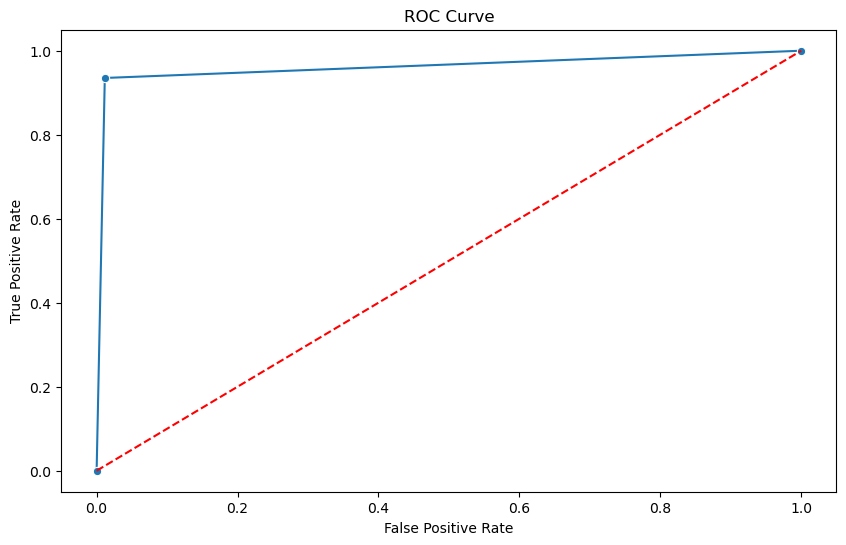

F1 Score: 0.9301075268817204


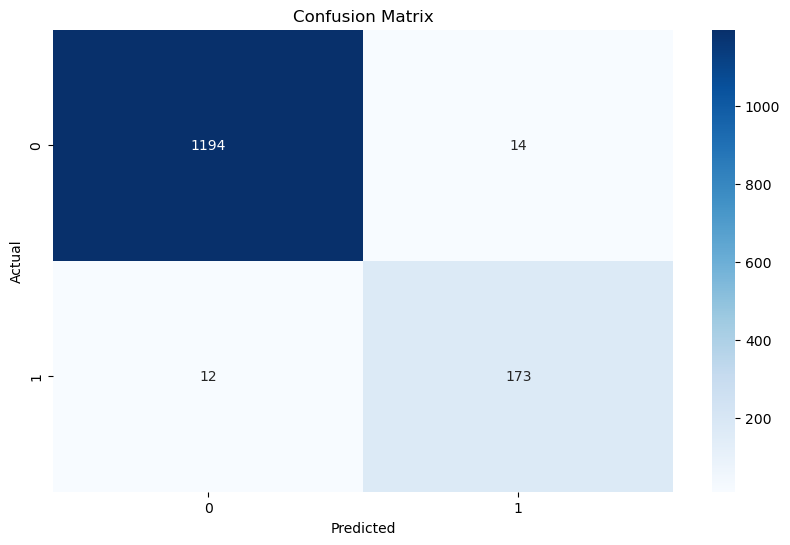

In [29]:
from sklearn.metrics import roc_curve, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(10, 6))
sns.lineplot(x=fpr, y=tpr, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print('F1 Score:', f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

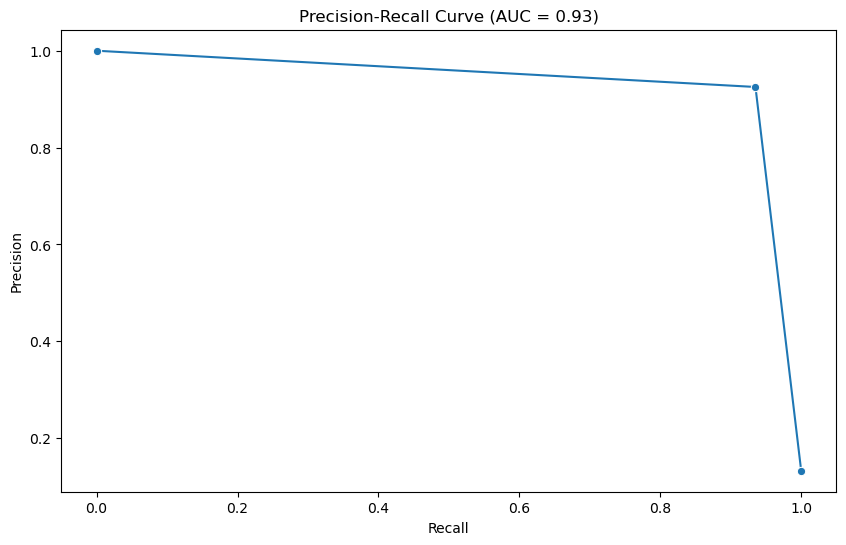

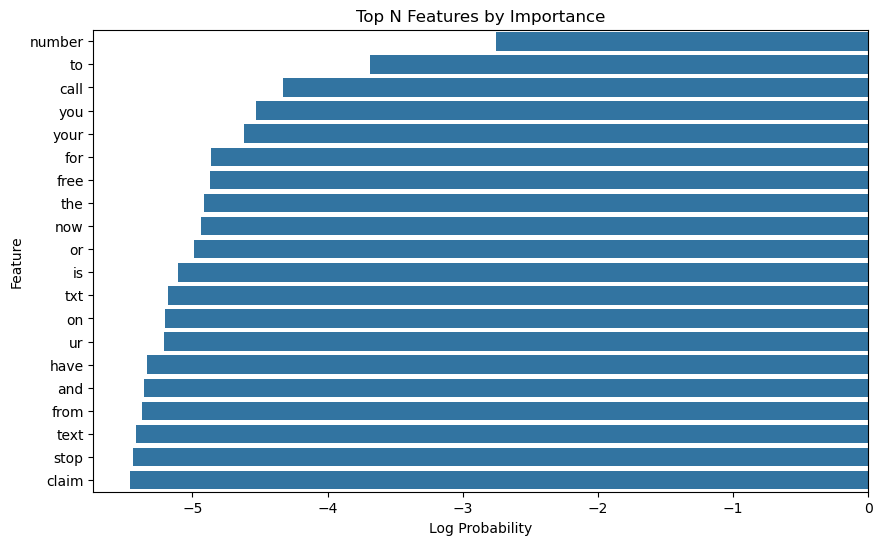

       Accuracy  Precision    Recall  F1 Score   AUC-ROC
Score  0.981335   0.925134  0.935135  0.930108  0.961773


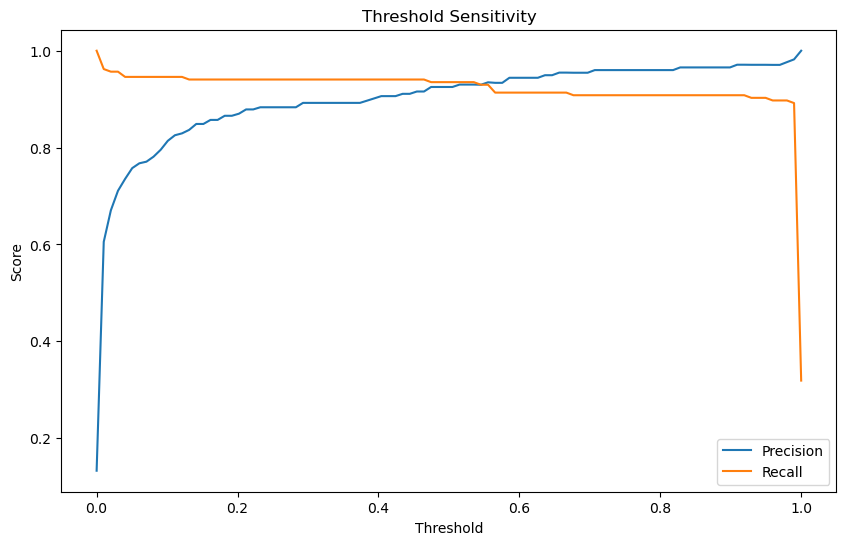

In [31]:
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10, 6))
sns.lineplot(x=recall, y=precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.show()

# 5. Feature Importance
vectorizer = clf.named_steps['vectorizer']
nb_model = clf.named_steps['nb']
feature_names = vectorizer.get_feature_names_out()
feature_log_prob = nb_model.feature_log_prob_[1]  # Log probabilities for spam class

# Get top N features
N = 20
top_n_indices = feature_log_prob.argsort()[-N:][::-1]
top_n_features = [feature_names[i] for i in top_n_indices]
top_n_importance = feature_log_prob[top_n_indices]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_n_importance, y=top_n_features)
plt.xlabel('Log Probability')
plt.ylabel('Feature')
plt.title('Top N Features by Importance')
plt.show()

# 6. Model Evaluation Metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'AUC-ROC': auc(fpr, tpr)
}

metrics_df = pd.DataFrame(metrics, index=['Score'])
print(metrics_df)

# 7. Threshold Sensitivity
thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_threshold = (clf.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred_threshold))
    recalls.append(recall_score(y_test, y_pred_threshold))

plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=precisions, label='Precision')
sns.lineplot(x=thresholds, y=recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sensitivity')
plt.legend()
plt.show()